In [72]:
from pomegranate import *

In [178]:
def path_to_alignment( x, y, path ):
    """
    This function will take in two sequences, and the ML path which is their alignment,
    and insert dashes appropriately to make them appear aligned. This consists only of
    adding a dash to the model sequence for every insert in the path appropriately, and
    a dash in the observed sequence for every delete in the path appropriately.
    """
    
    for i, (index, state) in enumerate( path[1:-1] ):
        name = state.name
        
        if name.startswith( 'D' ):
            y = y[:i] + '-' + y[i:]
        elif name.startswith( 'I' ):
            x = x[:i] + '-' + x[i:]

    return x, y

In [176]:
def make_model(target):
    model = HiddenMarkovModel()
    s = {}
    
    # add states
    i0 = State(DiscreteDistribution({ 'A': 0.25, 'C': 0.25, 'G': 0.25, 'T': 0.25 }), name="I0")
    model.add_state(i0)

    s[i0.name] = i0
    
    for c in range(len(target)):
        dc = State(None, name=f"D{c+1}")
        
        mc = State(DiscreteDistribution({
            "A": 0.94 if target[c] == 'A' else 0.02,
            "C": 0.94 if target[c] == 'C' else 0.02,
            "G": 0.94 if target[c] == 'G' else 0.02,
            "T": 0.94 if target[c] == 'T' else 0.02,
        }), name=f"M{c+1}")
        
        ic = State(DiscreteDistribution({ 'A': 0.25, 'C': 0.25, 'G': 0.25, 'T': 0.25 }), name=f"I{c+1}")

        model.add_states([mc, ic, dc])
        
        s[dc.name] = dc
        s[mc.name] = mc
        s[ic.name] = ic

    # add transitions
    model.add_transition(model.start, s['I0'], 0.05)
    model.add_transition(model.start, s['D1'], 0.05)
    model.add_transition(model.start, s['M1'], 0.90)
    
    model.add_transition(s['I0'], s['I0'], 0.70)
    model.add_transition(s['I0'], s['D1'], 0.15)
    model.add_transition(s['I0'], s['M1'], 0.15)
    
    for c in range(1, len(target)):
        model.add_transition(s[f'D{c}'], s[f'D{c+1}'], 0.15)
        model.add_transition(s[f'D{c}'], s[f'I{c}'],   0.70)
        model.add_transition(s[f'D{c}'], s[f'M{c+1}'], 0.15)
        
        model.add_transition(s[f'I{c}'], s[f'D{c+1}'], 0.15)
        model.add_transition(s[f'I{c}'], s[f'I{c}'],   0.15)
        model.add_transition(s[f'I{c}'], s[f'M{c+1}'], 0.70)

        model.add_transition(s[f'M{c}'], s[f'D{c+1}'], 0.05)
        model.add_transition(s[f'M{c}'], s[f'I{c}'],   0.05)
        model.add_transition(s[f'M{c}'], s[f'M{c+1}'], 0.90)
    
    model.add_transition(s[f'D{len(target)}'], s[f'I{len(target)}'], 0.70)
    model.add_transition(s[f'D{len(target)}'], model.end, 0.30)

    model.add_transition(s[f'I{len(target)}'], s[f'I{len(target)}'], 0.15)
    model.add_transition(s[f'I{len(target)}'], model.end, 0.85)

    model.add_transition(s[f'M{len(target)}'], s[f'I{len(target)}'], 0.90)
    model.add_transition(s[f'M{len(target)}'], model.end, 0.10)
        
    model.bake()
    
    return model

In [180]:
target = "ACT"

model = make_model(target)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Install pygraphviz for nicer visualizations
  """Entry point for launching an IPython kernel.


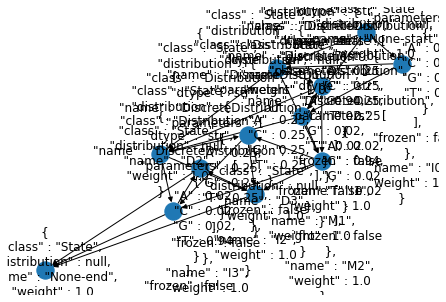

In [183]:
model.plot(with_labels=True)

In [181]:
for sequence in map(list, ('A', 'GA', 'AC', 'AT', 'ATCC')):
    logp, path = model.viterbi(sequence)
    x, y = path_to_alignment(target, ''.join(sequence), path)
    
    print(f"Sequence: {''.join(sequence)}, Log Probability: {logp}")
    print(f"{x}\n{y}")
    print("")

Sequence: A, Log Probability: -6.2640609821417215
ACT
A--

Sequence: GA, Log Probability: -10.438429782940773
AC-T-
--G-A

Sequence: AC, Log Probability: -4.534176916631755
ACT
AC-

Sequence: AT, Log Probability: -6.965576412372184
ACT-
A--T

Sequence: ATCC, Log Probability: -9.856176767823351
ACT-
ATCC

